## Insights from Visualization

- Train generator 1 -> Just not enough data to say anything
- Train generator 2 -> acce ts based 250ms cutline data. 553753 rows with only 10 sites, smallest wps count for site_floor is 3 with actual records 42, whereas the highest wps count is 835 with actual records 11724. It converges well with good accuracy. -> rmse_x: 0.61 rmse_y: 0.66 rmse_f: 0.017, comp metric at 0.67 -> But has no sites that are in the submission sites, so bad submission score
- Train generator 3 -> wps ts based with no cutline. 166681 rows with all 204 sites. It just doesn’t converge though -> rmse_x: 24.6 rmse_y: 21.8 rmse_f: 0.41 with comp metric at 30.1 -> Too large.
- Train generator 3M ->modify version 3 to only the 24 sites -> reduced to 75278 rows -> Still doesn’t converge. rmse_x: 23.8 rmse_y: 21.6 rmse_f: 0.36, comp metric at 29.6. -> Too large. Only wps maybe just isn't enough

- Train generator 2.1 -> acce_uncali ts based 100ms cutline data. Should cover all 204 site. Reduced to 100ms cutline because memory just won't hold. -> Need a way to convert 3.5G worth of pickle to datatable

In [2]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [3]:
!cp -r ../input/indoorlocationgithub/* ./

In [4]:
from io_f import read_data_file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

In [5]:
SEED = 42

In [8]:
!ls -la -h ../input/indoor4thtrain

total 1.5G
drwxr-xr-x  2 nobody nogroup    0 Mar 12 01:58 .
drwxr-xr-x 11 root   root    4.0K Mar 26 01:27 ..
-rw-r--r--  1 nobody nogroup 580M Mar 12 01:58 df_train_2.csv
-rw-r--r--  1 nobody nogroup 887M Mar 12 01:58 indoor_train_2.pkl


In [7]:
# train2 had better score even if it covered only 10 sites
# create similar dataset to train2 but with all the sites
# but maybe we just only got 10 sites for a reason (no acce_uncali etc)

# train_file_name = "../input/indoorfulltestgroupedtrain/indoor_train_2_site_group.pkl"
# train_file_name = "../input/indoor2ndtrain/indoor_train_2.pkl"
# train_file_name = "../input/indoor3rdtrain/indoor_train_3.pkl"
train_file_name = "../input/indoor4thtrain/indoor_train_4.pkl"
# test_file_name = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"
# dir_path = "../input/indoorpkl/"

# Load data it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

# with open(test_file_name, "rb") as file:
#     df_test = pickle.load(file)

# Uncomment below for making train 3M
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))

# Filter train data by the site_id of submission file
test_site_ids = sub_df["site"].unique()
print(test_site_ids)
df_train = df_train[df_train["site_id"].isin(test_site_ids)]
print(len(df_train))
print(df_train["site_id"].value_counts())

UnpicklingError: pickle data was truncated

In [196]:
# # set the index for test data
# df_test = df_test.set_index("site_path_timestamp")
# display(df_test.head())

In [197]:
# Train info
print("df len: ", len(df_train), "\n")
print("df column len: ", len(df_train.columns), "\n")
print("site_id nunique: ", df_train["site_id"].nunique(), "\n")
print("file_id nunique: ", df_train["file_id"].nunique(), "\n")
print("x nunique: ", df_train["x"].nunique(), "\n")
print("y nunique: ", df_train["y"].nunique(), "\n")
print("event ts nunique: ", df_train["ts"].nunique(), "\n")
print("start ts nunique: ", df_train["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts nunique: ", df_train["diff_ts_wp_ts"].nunique(), "\n")

df len:  75278 

df column len:  86 

site_id nunique:  24 

file_id nunique:  10877 

x nunique:  25454 

y nunique:  25445 

event ts nunique:  75275 

start ts nunique:  10877 

diff_ts_wp_ts nunique:  0 



In [151]:
# # Test info
# print("df len: ", len(df_test), "\n")
# print("df column len: ", len(df_test.columns), "\n")
# print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
# print("file_id nunique: ", df_test["file_id"].nunique(), "\n")
# print("x nunique: ", df_test["x"].nunique(), "\n")
# print("y nunique: ", df_test["y"].nunique(), "\n")
# print("event ts nunique: ", df_test["ts"].nunique(), "\n")
# print("start ts nunique: ", df_test["start_ts"].nunique(), "\n") # should be same length as file_id
# print("diff_ts_wp_ts nunique: ", df_test["diff_ts_wp_ts"].nunique(), "\n")

In [152]:
# test_site_id = df_test["site_id"].unique()
# train_site_id = df_train["site_id"].unique()
# print(test_site_id, "\n")
# print(train_site_id, "\n")
# a = list(set(test_site_id) & set(train_site_id))
# print(len(a))

In [153]:
# # print("test_df site_id value_counts: ", df_test["file_id"].value_counts(), "\n")
# # print("sub_df site_id value_counts: ", sub_df["file"].value_counts(), "\n")

# # Matching sites: 5d2709d403f801723c32bd39, 5dc8cea7659e181adb076a3f, 5d2709b303f801723c327472
# # Missing sites: 5dbc1d84c1eb61796cf7c010, 5da958dd46f8266d0737457b, 5d2709bb03f801723c32852c, 5d27096c03f801723c31e5e0

# # Matching files: f4bd7479dbe91f3d18f44c49, 4affd104e0ec7a7806edfa78, 610f2c07b26508790d1cd355
# # Missing files: d72ceac4628436a540910d98, 2b4bacedc942ffcb523ff20f, 876cd27fc8f63a2800fc3de8
# base_path = "../input/indoor-location-navigation/test/"
# match_path = "4affd104e0ec7a7806edfa78"
# missing_path = "d72ceac4628436a540910d98"

# match_path_full = base_path + match_path + ".txt"
# missing_path_full = base_path + missing_path + ".txt"

# #timestamps in sub_df
# sub_df_a = sub_df[sub_df["file"] == match_path]
# sub_df_a_ts = sorted(sub_df_a["timestamp"].value_counts().keys())
# print(sub_df_a_ts[0])
# df_test_match = df_test[(df_test["file_id"] == match_path) & (df_test["closest_wp_ts"] == int(sub_df_a_ts[0]))]
# display(df_test_match.head())

# sub_df_b = sub_df[sub_df["file"] == missing_path]
# sub_df_b_ts = sorted(sub_df_b["timestamp"].value_counts().keys())
# # display(sub_df_b.head())

# # ts for submission files
# print(sub_df_a_ts[:5], "\n")
# print(sub_df_b_ts[:5])

In [198]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [199]:
print(len(df_train.columns))
df_train = df_train.dropna(axis=1, how="all")
df_train = df_train.dropna(axis=0, how="any")
print(len(df_train.columns))

null_cols = df_train.columns[df_train.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_train, tqdm(null_cols), "site_id")

# null_cols = df_train.columns[df_train.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)
print("Current columns: ", df_train.columns)

86
73
Columns with nulls:  []
Current columns:  Index(['site_id', 'file_id', 'floor_converted', 'floor', 'ts', 'start_ts',
       'diff_start_ts', 'x', 'y', 'acce_ts', 'diff_acce_ts', 'acce_x',
       'acce_y', 'acce_z', 'ahrs_ts', 'diff_ahrs_ts', 'ahrs_x', 'ahrs_y',
       'ahrs_z', 'magn_ts', 'diff_magn_ts', 'magn_x', 'magn_y', 'magn_z',
       'magn_strength', 'gyro_ts', 'diff_gyro_ts', 'gyro_x', 'gyro_y',
       'gyro_z', 'acce_u_ts', 'diff_acce_u_ts', 'acce_u_x', 'acce_u_y',
       'acce_u_z', 'magn_u_ts', 'diff_magn_u_ts', 'magn_u_x', 'magn_u_y',
       'magn_u_z', 'gyro_u_ts', 'diff_gyro_u_ts', 'gyro_u_x', 'gyro_u_y',
       'gyro_u_z', 'wifi_ts', 'diff_wifi_ts', 'wifi_ssid', 'wifi_bssid',
       'wifi_rssi', 'wifi_last_seen_ts', 'beacon_ts', 'diff_beacon_ts',
       'beacon_ssid', 'beacon_rssi', 'rel_ts', 'diff_rel_ts', 'rel_x', 'rel_y',
       'site_id_le', 'file_id_le', 'floor_le', 'wifi_ssid_le', 'wifi_bssid_le',
       'beacon_ssid_le', 'ts_date', 'ts_day', 'ts_hour', 'ts_m

In [200]:
# column settings

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_500ms", "within_1000ms", "wifi_ssid", \
#                         "wifi_bssid", "beacon_ssid"] # train 2
categorical_features = ["site_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"] # train 3
int_features = ["floor_converted", "acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_train[col] = df_train[col].astype(int)

In [201]:
# print(df_train.dtypes[:50])
display(df_train.head())

,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
403,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,6.0,172.24472,64.679600,1.573973e+12,121.0,-0.517441,1.173737,12.516998,1.573973e+12,121.0,0.072908,0.032941,0.165753,1.573973e+12,121.0,13.973999,37.290955,-26.116943,47.623342,1.573973e+12,121.0,-0.780167,0.050293,-0.010468,1573972990161,121,0,1,11,1.573973e+12,121.0,4.856873,49.949646,-349.23248,1573972990161,121,0,0,0,1573972991176,1136,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972989947,1573972990120,80,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-73,1.573973e+12,737.0,-0.200423,0.528308,182,23259,10,8933,28170,13823,1573972990046000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972989947000064,1573948800000000000,1573970400000000000,1573972980000000000
404,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,2214.0,171.24260,67.290780,1.573973e+12,2207.0,-0.699402,-0.248413,7.754334,1.573973e+12,2207.0,0.077060,0.053680,0.125739,1.573973e+12,2207.0,10.504150,25.497437,-24.105835,36.627145,1.573973e+12,2207.0,-0.449402,-0.349182,-0.105286,1573972992247,2207,-1,0,7,1.573973e+12,2207.0,1.387024,38.156128,-347.22137,1573972992247,2207,0,0,0,1573972993124,3084,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-41,1573972991886,1573972992140,2100,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.573973e+12,2465.0,-0.196275,0.790519,182,23259,10,8933,28170,13823,1573972992254000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972991886000128,1573948800000000000,1573970400000000000,1573972980000000000
405,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,5204.0,169.95393,69.929695,1.573973e+12,5206.0,-1.180649,0.899597,10.319717,1.573973e+12,5206.0,0.028726,0.069171,0.198180,1.573973e+12,5206.0,13.973999,26.884460,-25.447083,39.567675,1.573973e+12,5206.0,-0.147400,-0.226685,-0.062668,1573972995246,5206,-1,0,9,1.573973e+12,5206.0,4.856873,39.543150,-348.56262,1573972995246,5206,0,0,0,1573972995068,5028,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972993830,1573972995332,5292,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-83,1.573973e+12,4649.0,-0.226396,0.554483,182,23259,10,8933,28170,13823,1573972995244000000,1573948800000000000,1573970400000000000,1573972980000000000,1573972993830000128,1573948800000000000,1573970400000000000,1573972980000000000
406,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,20182.0,157.84346,63.247593,1.573973e+12,20180.0,-1.685822,0.589554,10.933228,1.573973e+12,20180.0,-0.054669,0.058941,0.900884,1.573973e+12,20180.0,21.604920,-16.821290,-10.699463,29.397396,1.573973e+12,20180.0,-0.142609,-0.473297,0.138672,1573973010220,20180,-2,0,11,1.573973e+12,20180.0,12.487793,-4.162598,-333.81500,1573973010220,20180,0,0,0,1573973010748,20708,16e87293d966d1585459d6f333b74bf1b3e1883e,31e636b8c0acb6fb3bf8efa8a6e78990b8ba5fb2,-39,1573973009179,1573973010425,20385,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-67,1.573973e+12,20240.0,-0.661851,-0.550025,182,23259,10,852,5486,13823,1573973010222000128,15739488000000000

In [202]:
# dataset prep for training
target_x = df_train.iloc[:, 7]
target_y = df_train.iloc[:, 8]
target_f = df_train.iloc[:, 2]

# drop target columns
# drop_cols = ["file_id", "floor_converted", "floor", "x", "y"] # Train 2 test
drop_cols = ["file_id", "file_id_le", "floor_converted", "floor", "x", "y", "floor_le"] # Train 3
# drop_cols = ["file_id", "file_id_le", "floor_converted", "floor", \
#              "floor_converted_le", "x", "y"] # Train 2
# drop_cols = ["file_id", "file_id_le", "floor_converted", "floor", "floor_converted_le", "x", "y"]
features = df_train.drop(columns=drop_cols)
display(features.head())

# set target cols
targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = SEED)
    feat_train, feat_viz, target_train, target_viz = \
    train_test_split(feat_train, target_train, test_size = 0.2, random_state = SEED)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["feat_viz_{}".format(tgt)] = feat_viz
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["target_viz_{}".format(tgt)] = target_viz
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["feat_viz_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["target_viz_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
403,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,6.0,1.573973e+12,121.0,-0.517441,1.173737,12.516998,1.573973e+12,121.0,0.072908,0.032941,0.165753,1.573973e+12,121.0,13.973999,37.290955,-26.116943,47.623342,1.573973e+12,121.0,-0.780167,0.050293,-0.010468,1573972990161,121,0,1,11,1.573973e+12,121.0,4.856873,49.949646,-349.23248,1573972990161,121,0,0,0,1573972991176,1136,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972989947,1573972990120,80,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-73,1.573973e+12,737.0,-0.200423,0.528308,182,8933,28170,13823,1573972990046000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972989947000064,1573948800000000000,1573970400000000000,1573972980000000000
404,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,2214.0,1.573973e+12,2207.0,-0.699402,-0.248413,7.754334,1.573973e+12,2207.0,0.077060,0.053680,0.125739,1.573973e+12,2207.0,10.504150,25.497437,-24.105835,36.627145,1.573973e+12,2207.0,-0.449402,-0.349182,-0.105286,1573972992247,2207,-1,0,7,1.573973e+12,2207.0,1.387024,38.156128,-347.22137,1573972992247,2207,0,0,0,1573972993124,3084,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-41,1573972991886,1573972992140,2100,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.573973e+12,2465.0,-0.196275,0.790519,182,8933,28170,13823,1573972992254000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972991886000128,1573948800000000000,1573970400000000000,1573972980000000000
405,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,5204.0,1.573973e+12,5206.0,-1.180649,0.899597,10.319717,1.573973e+12,5206.0,0.028726,0.069171,0.198180,1.573973e+12,5206.0,13.973999,26.884460,-25.447083,39.567675,1.573973e+12,5206.0,-0.147400,-0.226685,-0.062668,1573972995246,5206,-1,0,9,1.573973e+12,5206.0,4.856873,39.543150,-348.56262,1573972995246,5206,0,0,0,1573972995068,5028,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972993830,1573972995332,5292,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-83,1.573973e+12,4649.0,-0.226396,0.554483,182,8933,28170,13823,1573972995244000000,1573948800000000000,1573970400000000000,1573972980000000000,1573972993830000128,1573948800000000000,1573970400000000000,1573972980000000000
406,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,20182.0,1.573973e+12,20180.0,-1.685822,0.589554,10.933228,1.573973e+12,20180.0,-0.054669,0.058941,0.900884,1.573973e+12,20180.0,21.604920,-16.821290,-10.699463,29.397396,1.573973e+12,20180.0,-0.142609,-0.473297,0.138672,1573973010220,20180,-2,0,11,1.573973e+12,20180.0,12.487793,-4.162598,-333.81500,1573973010220,20180,0,0,0,1573973010748,20708,16e87293d966d1585459d6f333b74bf1b3e1883e,31e636b8c0acb6fb3bf8efa8a6e78990b8ba5fb2,-39,1573973009179,1573973010425,20385,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-67,1.573973e+12,20240.0,-0.661851,-0.550025,182,852,5486,13823,1573973010222000128,1573948800000000000,1573970400000000000,1573972980000000000,1573973009179000064,1573948800000000000,1573970400000000000,1573972980000000000
407,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,22917.0,1.573973e+12,22921.0,-1.873169,1.176132,11.789749,1.573973e+12,22921.0,0.075779,-0.039078,-0.954615,1.573973

(42321, 66)
(13226, 66)
(10581, 66)
(42321,)
(13226,)
(10581,)
(42321, 66)
(42321,)
(13226, 66)
(13226,)
(42321, 66)
(13226, 66)
(10581, 66)
(42321,)
(13226,)
(10581,)
(42321, 66)
(42321,)
(13226, 66)
(13226,)
(42321, 66)
(13226, 66)
(10581, 66)
(42321,)
(13226,)
(10581,)
(42321, 66)
(42321,)
(13226, 66)
(13226,)


In [203]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 1000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 15,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22505
[LightGBM] [Info] Number of data points in the train set: 42321, number of used features: 66


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 114.939767
[1]	valid_0's rmse: 63.7927
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 60.8615
[3]	valid_0's rmse: 57.7898
[4]	valid_0's rmse: 55.431
[5]	valid_0's rmse: 53.1333
[6]	valid_0's rmse: 51.3043
[7]	valid_0's rmse: 49.6535
[8]	valid_0's rmse: 47.8081
[9]	valid_0's rmse: 46.3002
[10]	valid_0's rmse: 45.233
[11]	valid_0's rmse: 44.0626
[12]	valid_0's rmse: 42.9807
[13]	valid_0's rmse: 42.3245
[14]	valid_0's rmse: 41.7089
[15]	valid_0's rmse: 41.0982
[16]	valid_0's rmse: 40.1783
[17]	valid_0's rmse: 39.408
[18]	valid_0's rmse: 38.7324
[19]	valid_0's rmse: 38.1763
[20]	valid_0's rmse: 37.6035
[21]	valid_0's rmse: 37.2034
[22]	valid_0's rmse: 36.5951
[23]	valid_0's rmse: 36.1872
[24]	valid_0's rmse: 35.846
[25]	valid_0's rmse: 35.6092
[26]	valid_0's rmse: 35.3677
[27]	valid_0's rmse: 34.9156
[28]	valid_0's rmse: 34.5494
[29]	valid_0's rmse: 34.3276
[30]	valid_0's rmse: 34.0804
[31]	valid_0's rmse: 33.766

[287]	valid_0's rmse: 25.8516
[288]	valid_0's rmse: 25.8502
[289]	valid_0's rmse: 25.8441
[290]	valid_0's rmse: 25.8426
[291]	valid_0's rmse: 25.8327
[292]	valid_0's rmse: 25.8318
[293]	valid_0's rmse: 25.8152
[294]	valid_0's rmse: 25.8043
[295]	valid_0's rmse: 25.7897
[296]	valid_0's rmse: 25.7867
[297]	valid_0's rmse: 25.7856
[298]	valid_0's rmse: 25.7824
[299]	valid_0's rmse: 25.761
[300]	valid_0's rmse: 25.7444
[301]	valid_0's rmse: 25.7325
[302]	valid_0's rmse: 25.7254
[303]	valid_0's rmse: 25.7172
[304]	valid_0's rmse: 25.7164
[305]	valid_0's rmse: 25.7123
[306]	valid_0's rmse: 25.7067
[307]	valid_0's rmse: 25.7007
[308]	valid_0's rmse: 25.6977
[309]	valid_0's rmse: 25.6864
[310]	valid_0's rmse: 25.6847
[311]	valid_0's rmse: 25.6845
[312]	valid_0's rmse: 25.68
[313]	valid_0's rmse: 25.6768
[314]	valid_0's rmse: 25.6649
[315]	valid_0's rmse: 25.6603
[316]	valid_0's rmse: 25.658
[317]	valid_0's rmse: 25.64
[318]	valid_0's rmse: 25.641
[319]	valid_0's rmse: 25.639
[320]	valid_0's rm

[568]	valid_0's rmse: 24.6643
[569]	valid_0's rmse: 24.6654
[570]	valid_0's rmse: 24.6624
[571]	valid_0's rmse: 24.6651
[572]	valid_0's rmse: 24.6652
[573]	valid_0's rmse: 24.6625
[574]	valid_0's rmse: 24.6628
[575]	valid_0's rmse: 24.6608
[576]	valid_0's rmse: 24.6499
[577]	valid_0's rmse: 24.6443
[578]	valid_0's rmse: 24.6455
[579]	valid_0's rmse: 24.64
[580]	valid_0's rmse: 24.6417
[581]	valid_0's rmse: 24.6447
[582]	valid_0's rmse: 24.6447
[583]	valid_0's rmse: 24.6411
[584]	valid_0's rmse: 24.643
[585]	valid_0's rmse: 24.6426
[586]	valid_0's rmse: 24.6401
[587]	valid_0's rmse: 24.6341
[588]	valid_0's rmse: 24.6337
[589]	valid_0's rmse: 24.6303
[590]	valid_0's rmse: 24.6275
[591]	valid_0's rmse: 24.6258
[592]	valid_0's rmse: 24.6252
[593]	valid_0's rmse: 24.6253
[594]	valid_0's rmse: 24.6209
[595]	valid_0's rmse: 24.6167
[596]	valid_0's rmse: 24.6167
[597]	valid_0's rmse: 24.6172
[598]	valid_0's rmse: 24.6152
[599]	valid_0's rmse: 24.6139
[600]	valid_0's rmse: 24.6138
[601]	valid_0

[843]	valid_0's rmse: 24.3021
[844]	valid_0's rmse: 24.2991
[845]	valid_0's rmse: 24.2918
[846]	valid_0's rmse: 24.2876
[847]	valid_0's rmse: 24.2869
[848]	valid_0's rmse: 24.2871
[849]	valid_0's rmse: 24.2869
[850]	valid_0's rmse: 24.2853
[851]	valid_0's rmse: 24.2841
[852]	valid_0's rmse: 24.2821
[853]	valid_0's rmse: 24.2751
[854]	valid_0's rmse: 24.274
[855]	valid_0's rmse: 24.2747
[856]	valid_0's rmse: 24.2736
[857]	valid_0's rmse: 24.2711
[858]	valid_0's rmse: 24.2691
[859]	valid_0's rmse: 24.2693
[860]	valid_0's rmse: 24.2672
[861]	valid_0's rmse: 24.268
[862]	valid_0's rmse: 24.2685
[863]	valid_0's rmse: 24.2679
[864]	valid_0's rmse: 24.2691
[865]	valid_0's rmse: 24.2683
[866]	valid_0's rmse: 24.2675
[867]	valid_0's rmse: 24.2658
[868]	valid_0's rmse: 24.2585
[869]	valid_0's rmse: 24.2569
[870]	valid_0's rmse: 24.2581
[871]	valid_0's rmse: 24.2571
[872]	valid_0's rmse: 24.2576
[873]	valid_0's rmse: 24.2579
[874]	valid_0's rmse: 24.2554
[875]	valid_0's rmse: 24.2561
[876]	valid_

[108]	valid_0's rmse: 25.6442
[109]	valid_0's rmse: 25.6312
[110]	valid_0's rmse: 25.549
[111]	valid_0's rmse: 25.5057
[112]	valid_0's rmse: 25.4875
[113]	valid_0's rmse: 25.4787
[114]	valid_0's rmse: 25.4449
[115]	valid_0's rmse: 25.415
[116]	valid_0's rmse: 25.3847
[117]	valid_0's rmse: 25.3804
[118]	valid_0's rmse: 25.3444
[119]	valid_0's rmse: 25.2784
[120]	valid_0's rmse: 25.2663
[121]	valid_0's rmse: 25.2433
[122]	valid_0's rmse: 25.2284
[123]	valid_0's rmse: 25.2241
[124]	valid_0's rmse: 25.2117
[125]	valid_0's rmse: 25.2046
[126]	valid_0's rmse: 25.1418
[127]	valid_0's rmse: 25.1249
[128]	valid_0's rmse: 25.1044
[129]	valid_0's rmse: 25.0955
[130]	valid_0's rmse: 25.0823
[131]	valid_0's rmse: 25.0775
[132]	valid_0's rmse: 25.0581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's rmse: 25.0457
[134]	valid_0's rmse: 25.0445
[135]	valid_0's rmse: 25.0041
[136]	valid_0's rmse: 24.9862
[137]	valid_0's rmse: 24.9502
[138]	valid_0's rmse: 24.92

[393]	valid_0's rmse: 22.7671
[394]	valid_0's rmse: 22.7654
[395]	valid_0's rmse: 22.7647
[396]	valid_0's rmse: 22.7595
[397]	valid_0's rmse: 22.7562
[398]	valid_0's rmse: 22.7419
[399]	valid_0's rmse: 22.7347
[400]	valid_0's rmse: 22.7273
[401]	valid_0's rmse: 22.7207
[402]	valid_0's rmse: 22.7179
[403]	valid_0's rmse: 22.7063
[404]	valid_0's rmse: 22.6981
[405]	valid_0's rmse: 22.6965
[406]	valid_0's rmse: 22.6933
[407]	valid_0's rmse: 22.6861
[408]	valid_0's rmse: 22.6832
[409]	valid_0's rmse: 22.6815
[410]	valid_0's rmse: 22.6805
[411]	valid_0's rmse: 22.6803
[412]	valid_0's rmse: 22.6775
[413]	valid_0's rmse: 22.6781
[414]	valid_0's rmse: 22.6747
[415]	valid_0's rmse: 22.6757
[416]	valid_0's rmse: 22.677
[417]	valid_0's rmse: 22.6622
[418]	valid_0's rmse: 22.6566
[419]	valid_0's rmse: 22.657
[420]	valid_0's rmse: 22.6545
[421]	valid_0's rmse: 22.6573
[422]	valid_0's rmse: 22.6572
[423]	valid_0's rmse: 22.6599
[424]	valid_0's rmse: 22.6575
[425]	valid_0's rmse: 22.65
[426]	valid_0'

[681]	valid_0's rmse: 22.032
[682]	valid_0's rmse: 22.0339
[683]	valid_0's rmse: 22.028
[684]	valid_0's rmse: 22.0237
[685]	valid_0's rmse: 22.0158
[686]	valid_0's rmse: 22.0129
[687]	valid_0's rmse: 22.0105
[688]	valid_0's rmse: 22.0096
[689]	valid_0's rmse: 22.0031
[690]	valid_0's rmse: 22.0033
[691]	valid_0's rmse: 22.0021
[692]	valid_0's rmse: 22.002
[693]	valid_0's rmse: 22.0006
[694]	valid_0's rmse: 21.9976
[695]	valid_0's rmse: 22.0002
[696]	valid_0's rmse: 21.9985
[697]	valid_0's rmse: 21.999
[698]	valid_0's rmse: 21.9988
[699]	valid_0's rmse: 21.9965
[700]	valid_0's rmse: 21.9969
[701]	valid_0's rmse: 21.9965
[702]	valid_0's rmse: 21.9948
[703]	valid_0's rmse: 21.995
[704]	valid_0's rmse: 21.991
[705]	valid_0's rmse: 21.993
[706]	valid_0's rmse: 21.9936
[707]	valid_0's rmse: 21.9917
[708]	valid_0's rmse: 21.9943
[709]	valid_0's rmse: 21.991
[710]	valid_0's rmse: 21.9905
[711]	valid_0's rmse: 21.9869
[712]	valid_0's rmse: 21.9848
[713]	valid_0's rmse: 21.9816
[714]	valid_0's rm

[968]	valid_0's rmse: 21.6971
[969]	valid_0's rmse: 21.6945
[970]	valid_0's rmse: 21.6938
[971]	valid_0's rmse: 21.692
[972]	valid_0's rmse: 21.6936
[973]	valid_0's rmse: 21.6955
[974]	valid_0's rmse: 21.6953
[975]	valid_0's rmse: 21.6963
[976]	valid_0's rmse: 21.696
[977]	valid_0's rmse: 21.6944
[978]	valid_0's rmse: 21.6918
[979]	valid_0's rmse: 21.6909
[980]	valid_0's rmse: 21.6894
[981]	valid_0's rmse: 21.6865
[982]	valid_0's rmse: 21.6875
[983]	valid_0's rmse: 21.6855
[984]	valid_0's rmse: 21.6857
[985]	valid_0's rmse: 21.6852
[986]	valid_0's rmse: 21.6868
[987]	valid_0's rmse: 21.6864
[988]	valid_0's rmse: 21.6865
[989]	valid_0's rmse: 21.6853
[990]	valid_0's rmse: 21.6842
[991]	valid_0's rmse: 21.6821
[992]	valid_0's rmse: 21.6815
[993]	valid_0's rmse: 21.6793
[994]	valid_0's rmse: 21.6776
[995]	valid_0's rmse: 21.677
[996]	valid_0's rmse: 21.6765
[997]	valid_0's rmse: 21.6739
[998]	valid_0's rmse: 21.6719
[999]	valid_0's rmse: 21.6713
[1000]	valid_0's rmse: 21.6706
Did not meet

[228]	valid_0's rmse: 0.428498
[229]	valid_0's rmse: 0.427845
[230]	valid_0's rmse: 0.427439
[231]	valid_0's rmse: 0.427198
[232]	valid_0's rmse: 0.427059
[233]	valid_0's rmse: 0.426782
[234]	valid_0's rmse: 0.426414
[235]	valid_0's rmse: 0.426327
[236]	valid_0's rmse: 0.426001
[237]	valid_0's rmse: 0.425579
[238]	valid_0's rmse: 0.425158
[239]	valid_0's rmse: 0.425031
[240]	valid_0's rmse: 0.424968
[241]	valid_0's rmse: 0.424409
[242]	valid_0's rmse: 0.424113
[243]	valid_0's rmse: 0.42391
[244]	valid_0's rmse: 0.42357
[245]	valid_0's rmse: 0.423451
[246]	valid_0's rmse: 0.423069
[247]	valid_0's rmse: 0.422356
[248]	valid_0's rmse: 0.421869
[249]	valid_0's rmse: 0.421458
[250]	valid_0's rmse: 0.4211
[251]	valid_0's rmse: 0.420833
[252]	valid_0's rmse: 0.42054
[253]	valid_0's rmse: 0.420248
[254]	valid_0's rmse: 0.420267
[255]	valid_0's rmse: 0.419968
[256]	valid_0's rmse: 0.41991
[257]	valid_0's rmse: 0.419592
[258]	valid_0's rmse: 0.419171
[259]	valid_0's rmse: 0.419043
[260]	valid_0'

[494]	valid_0's rmse: 0.388299
[495]	valid_0's rmse: 0.388143
[496]	valid_0's rmse: 0.388074
[497]	valid_0's rmse: 0.388094
[498]	valid_0's rmse: 0.388074
[499]	valid_0's rmse: 0.388024
[500]	valid_0's rmse: 0.387959
[501]	valid_0's rmse: 0.387859
[502]	valid_0's rmse: 0.387828
[503]	valid_0's rmse: 0.387783
[504]	valid_0's rmse: 0.38776
[505]	valid_0's rmse: 0.387712
[506]	valid_0's rmse: 0.387721
[507]	valid_0's rmse: 0.387658
[508]	valid_0's rmse: 0.387593
[509]	valid_0's rmse: 0.387347
[510]	valid_0's rmse: 0.387223
[511]	valid_0's rmse: 0.387208
[512]	valid_0's rmse: 0.387102
[513]	valid_0's rmse: 0.387052
[514]	valid_0's rmse: 0.387028
[515]	valid_0's rmse: 0.387034
[516]	valid_0's rmse: 0.386899
[517]	valid_0's rmse: 0.386894
[518]	valid_0's rmse: 0.386905
[519]	valid_0's rmse: 0.38686
[520]	valid_0's rmse: 0.386742
[521]	valid_0's rmse: 0.386667
[522]	valid_0's rmse: 0.386697
[523]	valid_0's rmse: 0.386563
[524]	valid_0's rmse: 0.386526
[525]	valid_0's rmse: 0.386502
[526]	vali

[761]	valid_0's rmse: 0.375992
[762]	valid_0's rmse: 0.37596
[763]	valid_0's rmse: 0.375859
[764]	valid_0's rmse: 0.375839
[765]	valid_0's rmse: 0.375827
[766]	valid_0's rmse: 0.375821
[767]	valid_0's rmse: 0.375791
[768]	valid_0's rmse: 0.375787
[769]	valid_0's rmse: 0.375809
[770]	valid_0's rmse: 0.37585
[771]	valid_0's rmse: 0.375862
[772]	valid_0's rmse: 0.375857
[773]	valid_0's rmse: 0.375858
[774]	valid_0's rmse: 0.37581
[775]	valid_0's rmse: 0.37577
[776]	valid_0's rmse: 0.375716
[777]	valid_0's rmse: 0.375695
[778]	valid_0's rmse: 0.375683
[779]	valid_0's rmse: 0.375638
[780]	valid_0's rmse: 0.375639
[781]	valid_0's rmse: 0.37562
[782]	valid_0's rmse: 0.375584
[783]	valid_0's rmse: 0.375588
[784]	valid_0's rmse: 0.375568
[785]	valid_0's rmse: 0.375563
[786]	valid_0's rmse: 0.375579
[787]	valid_0's rmse: 0.375523
[788]	valid_0's rmse: 0.375451
[789]	valid_0's rmse: 0.375436
[790]	valid_0's rmse: 0.37536
[791]	valid_0's rmse: 0.375344
[792]	valid_0's rmse: 0.375342
[793]	valid_0'

In [204]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'feat_viz_x', 'target_train_x', 'target_val_x', 'target_viz_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'feat_viz_y', 'target_train_y', 'target_val_y', 'target_viz_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'feat_viz_f', 'target_train_f', 'target_val_f', 'target_viz_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
13226
13226


In [205]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 24.141885332128265 rmse_y: 21.670640974960488 rmse_f: 0.37003879051350014


In [206]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = np.array(d["target_val_f"]).astype(float)
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"],
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
comp metric:  29.987195987374722


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

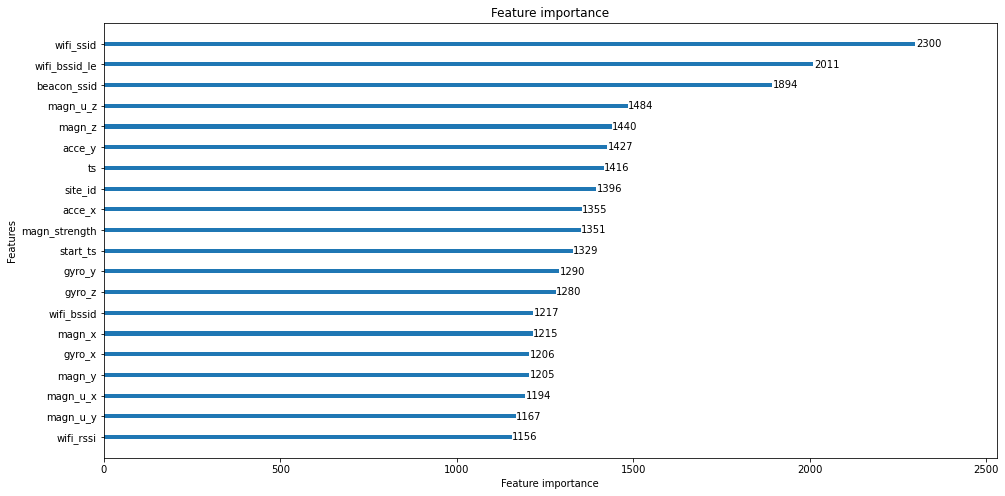

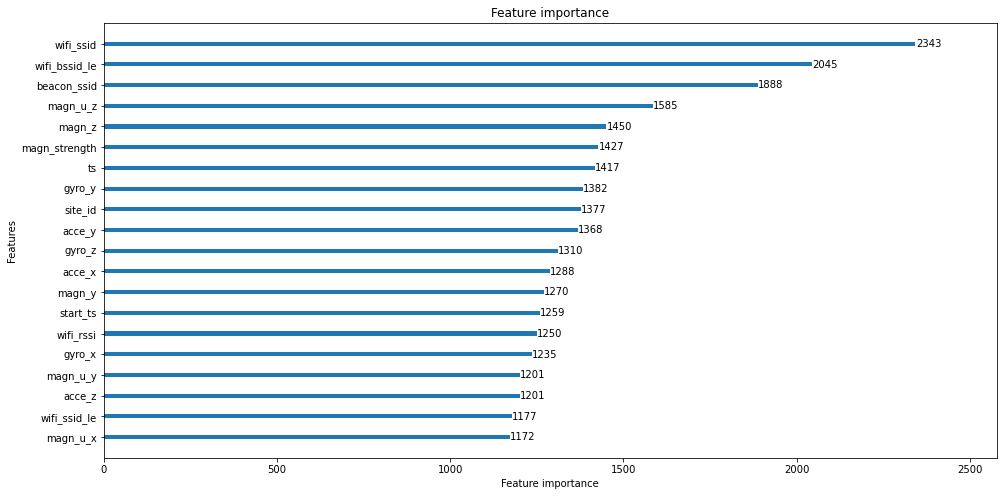

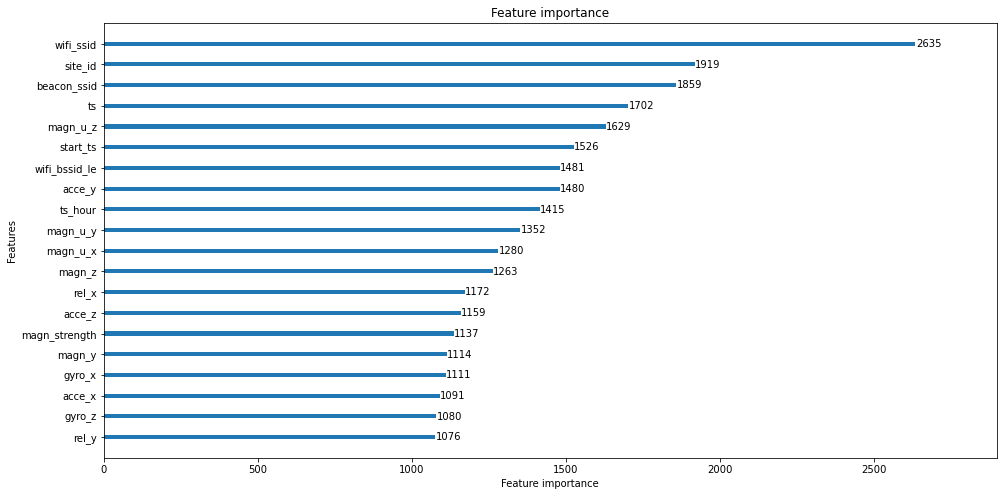

In [207]:
lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

---
## Use the trained model to predict viz data
---

In [208]:
# Run prediction against train data
print(d["feat_viz_x"].shape)
print(d["feat_viz_y"].shape)
print(d["target_viz_x"].shape)

(10581, 66)
(10581, 66)
(10581,)


In [209]:
# Make predictions using the viz data
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
viz_predsx = modelx.predict(d["feat_viz_x"])
viz_predsy = modely.predict(d["feat_viz_y"])
viz_predsf = modelf.predict(d["feat_viz_f"])

In [210]:
# quick check
# overlap_check = set(d["feat_viz_x"].index) ^ set(d["feat_viz_f"].index)
# print(overlap_check)

df_viz = d["feat_viz_x"]
df_viz["x"] = d["target_viz_x"]
df_viz["y"] = d["target_viz_y"]
df_viz["f"] = d["target_viz_f"]
df_viz["x_pred"] = viz_predsx
df_viz["y_pred"] = viz_predsy
df_viz["f_pred"] = viz_predsf
df_viz["x_diff"] = abs(df_viz["x"] - df_viz["x_pred"])
df_viz["y_diff"] = abs(df_viz["y"] - df_viz["y_pred"])
df_viz["f_diff"] = abs(df_viz["f"] - df_viz["f_pred"])

# create mix of site_id_le x floor
df_viz["site_le_f"] = "site_" + df_viz["site_id_le"].astype(str) + "_floor_" + df_viz["f"].astype(str)

# add difference measurement based on the competition's metric
df_viz["metric"] = np.sqrt((df_viz["x"] - df_viz["x_pred"])**2 + (df_viz["y"] - df_viz["y_pred"])**2) + (15 * abs(df_viz["f"] - df_viz["f_pred"]))

display(df_viz.head())
print(len(viz_predsx))

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
40840,5a0546857ecc773753327266,1.578475e+12,1.578475e+12,19.0,1.578475e+12,146.0,-0.195374,4.429993,8.859329,1.578475e+12,146.0,0.176960,0.147564,0.562040,1.578475e+12,146.0,29.173279,-1.922607,-24.125671,37.905470,1.578475e+12,146.0,-0.194672,-0.052048,-0.050400,1578475359815,146,0,4,8,1.578475e+12,146.0,33.299255,6.243896,-363.15002,1578475359815,146,0,0,0,1578475361855,2186,ab150ecf6d972b476aeab16317bed6189d9f7cce,323607d8444900d64151ee06d164738ac727bbce,-45,1578475359755,1578475359780,111,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-80,1.578475e+12,771.0,-0.371389,0.148559,0,6054,5529,13823,1578475359688000000,1578441600000000000,1578474000000000000,1578475320000000000,1578475359755000064,1578441600000000000,1578474000000000000,1578475320000000000,102.662500,76.862010,0,77.235557,61.489791,0.004359,25.426943,15.372219,0.004359,site_0_floor_0,29.777915
143918,5dbc1d84c1eb61796cf7c010,1.574254e+12,1.574254e+12,8472.0,1.574254e+12,8470.0,-0.485123,-0.924194,10.866196,1.574254e+12,8470.0,-0.036235,-0.040263,0.993455,1.574254e+12,8470.0,4.261780,-12.594605,-19.941711,23.967867,1.574254e+12,8470.0,-0.006943,-0.315079,0.083786,1574254184904,8470,0,0,10,1.574254e+12,8470.0,-36.769104,-137.362670,-317.72766,1574254184904,8470,0,0,0,1574254184161,7727,8f7d5669fb8464cd2eef926f246adaac8050b848,769eeca6ded625ba26d269ad5aeb325ab213db10,-43,1574254157428,1574254184721,8287,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-85,1.574254e+12,8470.0,-0.125337,-0.621656,202,5023,13192,10717,1574254184905999872,1574208000000000000,1574251200000000000,1574254140000000000,1574254157428000000,1574208000000000000,1574251200000000000,1574254140000000000,179.955640,61.736046,5,165.374735,93.110600,4.742920,14.580905,31.374554,0.257080,site_202_floor_5,38.453394
40730,5a0546857ecc773753327266,1.578477e+12,1.578477e+12,17231.0,1.578477e+12,17240.0,0.491165,4.290543,8.480453,1.578477e+12,17240.0,0.253429,-0.164088,-0.621925,1.578477e+12,17240.0,-28.388977,-11.137390,-25.593567,39.812136,1.578477e+12,17240.0,-0.213837,-0.161774,-0.295929,1578477223488,17240,0,4,8,1.578477e+12,17240.0,-27.056885,-2.081299,-365.17487,1578477223488,17240,0,0,0,1578477224615,18367,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,5df57fca60cb48fac97a573ea4f2bd3a85f045f4,-49,1578477223579,1578477223393,17145,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.578477e+12,17422.0,0.456207,0.012108,0,7731,10430,13823,1578477223479000064,1578441600000000000,1578474000000000000,1578477180000000000,1578477223579000064,1578441600000000000,1578474000000000000,1578477180000000000,82.560680,37.360947,0,78.415782,54.491943,0.057902,4.144898,17.130996,0.057902,site_0_floor_0,18.493834
33335,5da1389e4db8ce0c98bd0547,1.573269e+12,1.573269e+12,106789.0,1.573269e+12,106793.0,-0.835052,4.171051,6.339966,1.573269e+12,106793.0,-0.050352,0.202481,0.976637,1.573269e+12,106793.0,5.029297,-42.657470,-16.725159,46.094300,1.573269e+12,106793.0,0.095734,-0.254944,0.335770,1573268729302,106793,-1,4,6,1.573269e+12,106793.0,-35.588074,-54.435730,-360.10284,1573268729302,106793,0,0,0,1573268729741,107232,0e41516011e82dba712d3fd8e76ad7fa560aa51c,cc7126e6b9242e07a8074aa05c7083fa4dbd865d,-63,1573268720313,1573268689239,66730,89cb11b04122cef23388b0da06bd4

10581


In [211]:
# set sites with most/mid/least counts
site_le_f_counts = df_viz["site_le_f"].value_counts()
site_most_count = site_le_f_counts.idxmax()
site_least_count = site_le_f_counts.idxmin()
site_mid_count = int(len(site_le_f_counts) / 2)
site_count_list = df_viz["site_le_f"].value_counts().index.tolist()

print("site_floor with most count: ", site_most_count, "->", site_le_f_counts[site_most_count])
print("site_floor with mid count: ", site_count_list[site_mid_count], "->", site_le_f_counts[site_count_list[site_mid_count]])
print("site_floor with least count: ", site_least_count, "->", site_le_f_counts[site_least_count])

site_floor with most count:  site_180_floor_0 -> 344
site_floor with mid count:  site_194_floor_-1 -> 66
site_floor with least count:  site_192_floor_2 -> 4


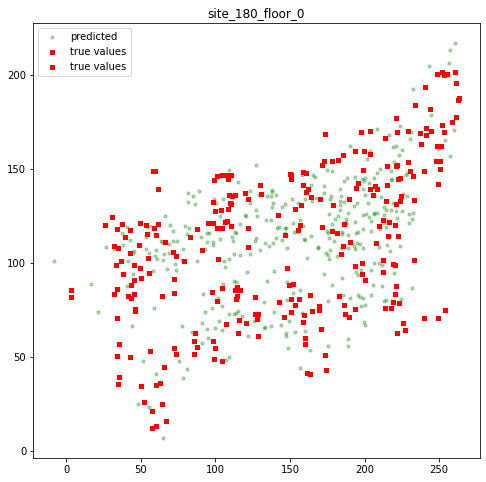

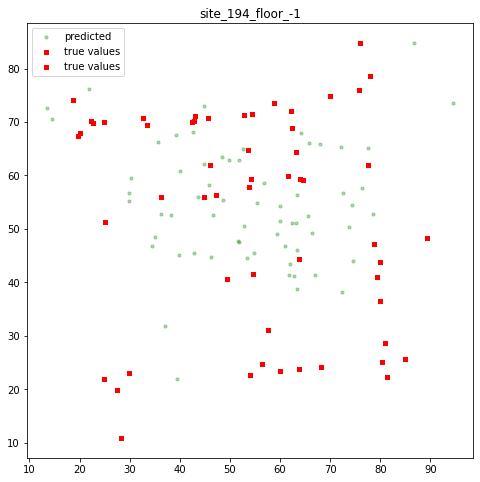

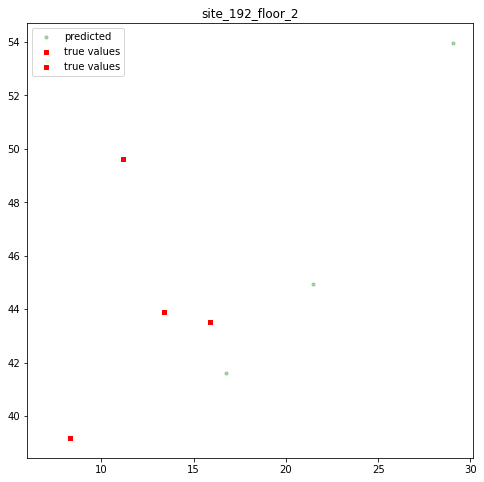

In [212]:
x_max = df_viz["x"].max()
x_min = df_viz["x"].min()
y_max = df_viz["y"].max()
y_min = df_viz["y"].min()

# Plot predictions against ground truths
def plot_gt_pred(site, scale=True):
    df_viz_a = df_viz[df_viz["site_le_f"] == site] # most counts
    x = df_viz_a["x"]
    y = df_viz_a["y"]
    x_pred = df_viz_a["x_pred"]
    y_pred = df_viz_a["y_pred"]

    fig = plt.figure(figsize=(8,8))
    fig.patch.set_facecolor("white")
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_pred, y_pred, s=10, c="g", marker="o", label="predicted", alpha=0.3)
    ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
    ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
    if scale == True:
        ax1.set_xlim([x_min, x_max])
        ax1.set_ylim([y_min, y_max])
    ax1.set_title(site)
    plt.legend(loc='upper left');
    plt.show()

plot_gt_pred(site_most_count, scale=False)
plot_gt_pred(site_count_list[site_mid_count], scale=False)
plot_gt_pred(site_least_count, scale=False)

# plot_gt_pred(site_most_count, scale=True)
# plot_gt_pred(site_count_list[site_mid_count], scale=True)
# plot_gt_pred(site_least_count, scale=True)

In [213]:
# Take difference of truth - predicted -> which has the largest difference
display(df_viz.head())
print(len(df_viz))
print(df_viz["ts"].nunique())

# # train 2
# df_viz_grouped = df_viz.groupby("site_le_f").agg({"site_le_f": "count", \
#                                                   "closest_wp_ts": lambda x: x.nunique(), \
#                                                   "x_diff": "mean", "y_diff": "mean", \
#                                                   "f_diff": "mean", "metric": "mean"
#                                                  })
# df_viz_grouped = df_viz_grouped.sort_values(by=["closest_wp_ts"], ascending=False)

# train 3
df_viz_grouped = df_viz.groupby("site_le_f").agg({"site_le_f": "count", \
                                                  "ts": lambda x: x.nunique(), \
                                                  "x_diff": "mean", "y_diff": "mean", \
                                                  "f_diff": "mean", "metric": "mean"
                                                 })
df_viz_grouped = df_viz_grouped.sort_values(by=["ts"], ascending=False)
print(len(df_viz_grouped))
display(df_viz_grouped)

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
40840,5a0546857ecc773753327266,1.578475e+12,1.578475e+12,19.0,1.578475e+12,146.0,-0.195374,4.429993,8.859329,1.578475e+12,146.0,0.176960,0.147564,0.562040,1.578475e+12,146.0,29.173279,-1.922607,-24.125671,37.905470,1.578475e+12,146.0,-0.194672,-0.052048,-0.050400,1578475359815,146,0,4,8,1.578475e+12,146.0,33.299255,6.243896,-363.15002,1578475359815,146,0,0,0,1578475361855,2186,ab150ecf6d972b476aeab16317bed6189d9f7cce,323607d8444900d64151ee06d164738ac727bbce,-45,1578475359755,1578475359780,111,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-80,1.578475e+12,771.0,-0.371389,0.148559,0,6054,5529,13823,1578475359688000000,1578441600000000000,1578474000000000000,1578475320000000000,1578475359755000064,1578441600000000000,1578474000000000000,1578475320000000000,102.662500,76.862010,0,77.235557,61.489791,0.004359,25.426943,15.372219,0.004359,site_0_floor_0,29.777915
143918,5dbc1d84c1eb61796cf7c010,1.574254e+12,1.574254e+12,8472.0,1.574254e+12,8470.0,-0.485123,-0.924194,10.866196,1.574254e+12,8470.0,-0.036235,-0.040263,0.993455,1.574254e+12,8470.0,4.261780,-12.594605,-19.941711,23.967867,1.574254e+12,8470.0,-0.006943,-0.315079,0.083786,1574254184904,8470,0,0,10,1.574254e+12,8470.0,-36.769104,-137.362670,-317.72766,1574254184904,8470,0,0,0,1574254184161,7727,8f7d5669fb8464cd2eef926f246adaac8050b848,769eeca6ded625ba26d269ad5aeb325ab213db10,-43,1574254157428,1574254184721,8287,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-85,1.574254e+12,8470.0,-0.125337,-0.621656,202,5023,13192,10717,1574254184905999872,1574208000000000000,1574251200000000000,1574254140000000000,1574254157428000000,1574208000000000000,1574251200000000000,1574254140000000000,179.955640,61.736046,5,165.374735,93.110600,4.742920,14.580905,31.374554,0.257080,site_202_floor_5,38.453394
40730,5a0546857ecc773753327266,1.578477e+12,1.578477e+12,17231.0,1.578477e+12,17240.0,0.491165,4.290543,8.480453,1.578477e+12,17240.0,0.253429,-0.164088,-0.621925,1.578477e+12,17240.0,-28.388977,-11.137390,-25.593567,39.812136,1.578477e+12,17240.0,-0.213837,-0.161774,-0.295929,1578477223488,17240,0,4,8,1.578477e+12,17240.0,-27.056885,-2.081299,-365.17487,1578477223488,17240,0,0,0,1578477224615,18367,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,5df57fca60cb48fac97a573ea4f2bd3a85f045f4,-49,1578477223579,1578477223393,17145,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.578477e+12,17422.0,0.456207,0.012108,0,7731,10430,13823,1578477223479000064,1578441600000000000,1578474000000000000,1578477180000000000,1578477223579000064,1578441600000000000,1578474000000000000,1578477180000000000,82.560680,37.360947,0,78.415782,54.491943,0.057902,4.144898,17.130996,0.057902,site_0_floor_0,18.493834
33335,5da1389e4db8ce0c98bd0547,1.573269e+12,1.573269e+12,106789.0,1.573269e+12,106793.0,-0.835052,4.171051,6.339966,1.573269e+12,106793.0,-0.050352,0.202481,0.976637,1.573269e+12,106793.0,5.029297,-42.657470,-16.725159,46.094300,1.573269e+12,106793.0,0.095734,-0.254944,0.335770,1573268729302,106793,-1,4,6,1.573269e+12,106793.0,-35.588074,-54.435730,-360.10284,1573268729302,106793,0,0,0,1573268729741,107232,0e41516011e82dba712d3fd8e76ad7fa560aa51c,cc7126e6b9242e07a8074aa05c7083fa4dbd865d,-63,1573268720313,1573268689239,66730,89cb11b04122cef23388b0da06bd4

10581
10581
139


,site_le_f,ts,x_diff,y_diff,f_diff,metric
site_le_f,,,,,,
site_180_floor_0,344,344.0,22.808162,17.834050,0.144638,33.162051
site_180_floor_1,257,257.0,22.500557,15.673719,0.252046,33.912037
site_180_floor_2,229,229.0,22.748672,14.535943,0.182435,32.148514
site_189_floor_-1,184,184.0,14.767177,13.640833,0.128825,23.879010
site_196_floor_0,180,180.0,18.200317,14.577913,0.191173,28.481503
...,...,...,...,...,...,...
site_189_floor_2,10,10.0,9.545602,5.093556,0.178159,14.067284
site_182_floor_4,9,9.0,13.634396,12.790403,0.087591,20.861883
site_180_floor_5,9,9.0,22.516859,10.128428,0.077013,26.748609


supposed_comp_metric:  29.473806733191577


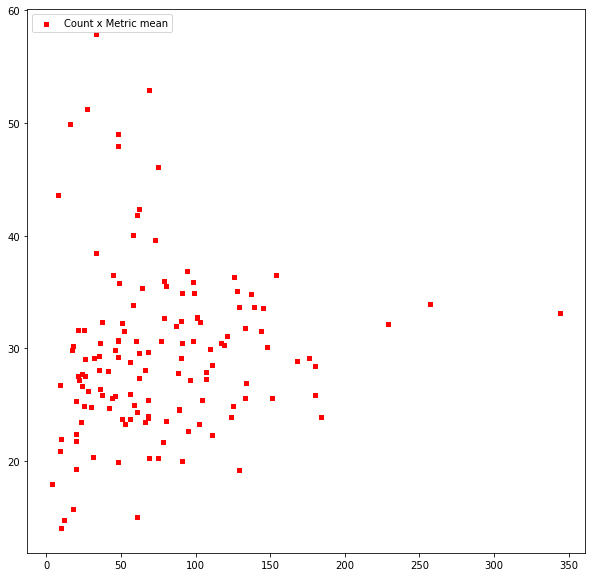

In [214]:
supposed_comp_metric = df_viz_grouped["metric"].mean()
print("supposed_comp_metric: ", supposed_comp_metric)

# Visualize count and comp metric
a = df_viz_grouped["site_le_f"]
b = df_viz_grouped["metric"]

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(a, b, s=10, c="r", marker="s", label="Count x Metric mean")
plt.legend(loc='upper left');
plt.show()

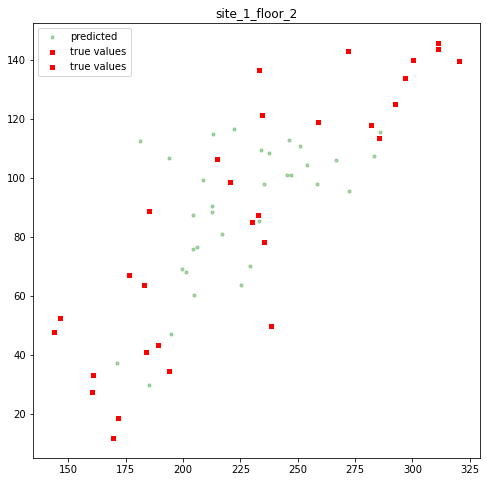

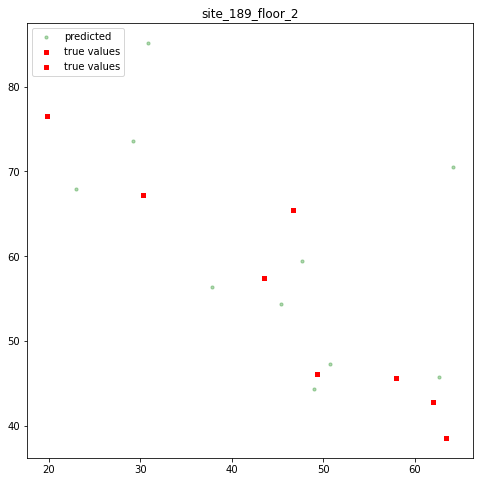

In [215]:
# Try seeing other sites with high metric mean
metric_higest = df_viz_grouped["metric"].idxmax()
metric_lowest = df_viz_grouped["metric"].idxmin()

plot_gt_pred(metric_higest, scale=False)
plot_gt_pred(metric_lowest, scale=False)

In [216]:
# Plot ground truth and predictions on actual map
# Low metric mean -> waypoints are scattered, and intervals seem sparce
# Set scales right for all graphs

---
## Making Quick Prediction
---

In [217]:
# Visualize differences between test 2 and test 3
!ls -la -h ../input/indoorfulltestgroupedtrain

total 529M
drwxr-xr-x  2 nobody nogroup    0 Mar 18 04:58 .
drwxr-xr-x 10 root   root    4.0K Mar 25 07:00 ..
-rw-r--r--  1 nobody nogroup 385M Mar 18 04:58 indoor_test_2_250ms.pkl
-rw-r--r--  1 nobody nogroup 153M Mar 18 04:58 indoor_train_2_site_group.pkl


In [218]:
test_2 = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"
test_3 = "../input/indoor3rdtest/indoor_test_3.pkl"

with open(test_2, "rb") as file:
    df_test_2 = pickle.load(file)

with open(test_3, "rb") as file:
    df_test_3 = pickle.load(file)

### Test Visualization: Diff timestamp distribution

In [219]:
# # Check if either is missing some data that should be there
# test2_ts_id = df_test_2["site_path_timestamp"].unique()
# test3_ts_id = df_test_3["site_path_timestamp"].unique()
# print("len of test2_ts_id", len(test2_ts_id))
# print("len of test3_ts_id", len(test3_ts_id), "\n")
# no_overlap_ts = set(test2_ts_id) ^ set(test3_ts_id)
# print("not overlapping ts", no_overlap_ts)

# # Check columns are the same
# print(len(df_test_2))
# print(len(df_test_3))
# no_overlap_col = set(df_test_2.columns) ^ set(df_test_3.columns)
# print("not overlapping columns", no_overlap_col)

# # Check the diff timestamps -> check if we're not picking up something that are just too far away from ts
# def print_minmax(df, cols):
#     for col in cols:
#         print("col: ", col)
#         print("max: ", df[col].max())
#         print("min: ", df[col].min())

# check_diff_cols = ["diff_acce_ts", "diff_ahrs_ts", "diff_magn_ts", \
#                    "diff_gyro_ts", "diff_acce_u_ts", "diff_magn_u_ts", \
#                    "diff_gyro_u_ts", "diff_wifi_ts", "diff_beacon_ts", \
#                    "diff_rel_ts"]

# print("~~~~~~~~~~~~~~~~~~~~~~~~")
# print("test 2 range: ")
# print_minmax(df_test_2, check_diff_cols)
# print("~~~~~~~~~~~~~~~~~~~~~~~~", "\n")

# print("~~~~~~~~~~~~~~~~~~~~~~~~")
# print("test 3 range: ")
# print_minmax(df_test_3, check_diff_cols)

In [220]:
# def bin_plot(df, col, title, x_label, y_label):
#     min_v = pd.to_numeric(df[col]).min()
#     max_v = pd.to_numeric(df[col]).max()
#     diff = max_v - min_v
#     fig = plt.figure(figsize=(16.0, 4.0))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(1,1,1)
#     ax.hist(df[col], bins=30)
#     ax.set_title(title)
#     # ax.set_xlabel(x_label)
#     ax.text(0.01, 0.99, "min is {}, max is {}, diff is {}".format(min_v, max_v, diff), verticalalignment='top', transform=ax.transAxes)
#     ax.set_ylabel(y_label)
#     plt.xticks(rotation=90)
#     fig.show()


# check_diff_cols = ["diff_acce_ts", "diff_ahrs_ts", "diff_magn_ts", \
#                    "diff_gyro_ts", "diff_acce_u_ts", "diff_magn_u_ts", \
#                    "diff_gyro_u_ts", "diff_wifi_ts", "diff_beacon_ts", \
#                    "diff_rel_ts"]

# df_test_2.name = "df_test_2"
# df_test_3.name = "df_test_3"

# for df in [df_test_2, df_test_3]:
#     for col in check_diff_cols:
#         df_title = "df_test_2" if df.name == "df_test_2" else "df_test_3"
#         bin_plot(df, col, f"{df_title} --- {col}", f"{col}", "freq")

In [221]:
# # Prune the outliers -> For acce etc @ ±200ms, for wifi&rel @ ±2500ms, for beacon @
# # print(len(df_test_3))
# a = df_test_3[abs(df_test_3["diff_acce_ts"]) > 200]
# b = df_test_3[abs(df_test_3["diff_wifi_ts"]) > 2500]
# c = df_test_3[abs(df_test_3["diff_beacon_ts"]) > 10000]
# d = df_test_3[abs(df_test_3["diff_rel_ts"]) > 2500]
# print(df_test_3["diff_acce_ts"].mean())
# print(df_test_3["diff_wifi_ts"].mean())
# print(df_test_3["diff_beacon_ts"].mean())
# print(df_test_3["diff_rel_ts"].mean())
# print("\n")
# print(df_test_3["diff_acce_ts"].std())
# print(df_test_3["diff_wifi_ts"].std())
# print(df_test_3["diff_beacon_ts"].std())
# print(df_test_3["diff_rel_ts"].std())
# print("\n")
# print(len(a))
# print(len(b))
# print(len(c))
# print(len(d))
# df_test_3.info()
# # df_test_3["diff_beacon_ts"]
# # df_test_3["diff_rel_ts"]

### ↑Til here, so don't delete these cells

In [222]:
display(df_test_3.head())
display(features.head())

,site_path_timestamp,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_250ms,within_500ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9.0,0.0,9.0,NaN,NaN,9.0,9.0,9.0,NaN,NaN,136.0,127.0,0.798813,4.300720,7.810059,NaN,136.0,127.0,0.247101,0.104201,0.474897,NaN,136.0,127.0,30.561829,-1.228333,-38.301086,NaN,49.015379,136.0,127.0,-0.039139,-0.507996,-0.148392,NaN,136.0,127.0,0.578552,4.353989,8.195526,NaN,136.0,127.0,34.687805,6.938171,-377.32544,NaN,136.0,127.0,-0.077835,-0.334671,-0.166565,NaN,2340.0,2331.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,82.0,73.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87.0,1144.0,1135.0,-0.425353,0.248690,0,6,0,1426,3861,1694,1970-01-01 00:00:00.009,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9017.0,0.0,9017.0,NaN,NaN,9017.0,9017.0,9017.0,NaN,NaN,9012.0,-5.0,-1.106979,4.056503,9.795456,NaN,9012.0,-5.0,0.162119,0.185954,0.561409,NaN,9012.0,-5.0,29.867554,-6.085205,-26.150513,NaN,40.161547,9012.0,-5.0,-0.045532,-0.498398,-0.557999,NaN,9012.0,-5.0,-1.214722,4.168442,9.794861,NaN,9012.0,-5.0,33.993530,2.081299,-365.17487,NaN,9012.0,-5.0,-0.224304,-0.391663,-0.471771,NaN,9508.0,491.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-43.0,NaN,1.578475e+12,9040.0,23.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-69.0,8830.0,-187.0,-0.537325,0.140535,0,6,0,1426,514,1694,1970-01-01 00:00:09.017,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:30.052000000,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,15326.0,0.0,15326.0,NaN,NaN,15326.0,15326.0,15326.0,NaN,NaN,15326.0,0.0,-0.572464,3.981689,7.082230,NaN,15326.0,0.0,0.225070,0.022647,-0.200452,NaN,15326.0,0.0,-6.207275,14.727783,-39.649963,NaN,42.749941,15326.0,0.0,-0.185089,-0.110107,-0.424301,NaN,15326.0,0.0,-0.607178,3.937988,6.426224,NaN,15326.0,0.0,-2.081299,22.894287,-378.67432,NaN,15326.0,0.0,0.012177,0.033920,-0.356186,NaN,14714.0,-612.0,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b26914599f6d9ba16b43975394e1eeb9d82f4bab,-41.0,NaN,1.578475e+12,15393.0,67.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-65.0,15487.0,161.0,0.295503,0.550062,0,6,0,1180,2934,1694,1970-01-01 00:00:15.326,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:38.027000064,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,18763.0,0.0,18763.0,NaN,NaN,18763.0,18763.0,18763.0,NaN,NaN,18755.0,-8.0,-0.751434,4.546112,10.231201,NaN,18755.0,-8.0,0.225055,0.044806,-0.119175,NaN,18755.0,-8.0,-1.350403,9.870911,-41.676330,NaN,42.850612,18755.0,-8.0,0.225586,-0.058456,-0.224564,NaN,18755.0,-8.0,-0.889694,4.286942,10.229401,NaN,18755.0,-8.0,2.775574,18.037415,-380.70068,NaN,18755.0,-8.0,-0.060791

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
403,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,6.0,1.573973e+12,121.0,-0.517441,1.173737,12.516998,1.573973e+12,121.0,0.072908,0.032941,0.165753,1.573973e+12,121.0,13.973999,37.290955,-26.116943,47.623342,1.573973e+12,121.0,-0.780167,0.050293,-0.010468,1573972990161,121,0,1,11,1.573973e+12,121.0,4.856873,49.949646,-349.23248,1573972990161,121,0,0,0,1573972991176,1136,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972989947,1573972990120,80,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-73,1.573973e+12,737.0,-0.200423,0.528308,182,8933,28170,13823,1573972990046000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972989947000064,1573948800000000000,1573970400000000000,1573972980000000000
404,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,2214.0,1.573973e+12,2207.0,-0.699402,-0.248413,7.754334,1.573973e+12,2207.0,0.077060,0.053680,0.125739,1.573973e+12,2207.0,10.504150,25.497437,-24.105835,36.627145,1.573973e+12,2207.0,-0.449402,-0.349182,-0.105286,1573972992247,2207,-1,0,7,1.573973e+12,2207.0,1.387024,38.156128,-347.22137,1573972992247,2207,0,0,0,1573972993124,3084,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-41,1573972991886,1573972992140,2100,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.573973e+12,2465.0,-0.196275,0.790519,182,8933,28170,13823,1573972992254000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972991886000128,1573948800000000000,1573970400000000000,1573972980000000000
405,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,5204.0,1.573973e+12,5206.0,-1.180649,0.899597,10.319717,1.573973e+12,5206.0,0.028726,0.069171,0.198180,1.573973e+12,5206.0,13.973999,26.884460,-25.447083,39.567675,1.573973e+12,5206.0,-0.147400,-0.226685,-0.062668,1573972995246,5206,-1,0,9,1.573973e+12,5206.0,4.856873,39.543150,-348.56262,1573972995246,5206,0,0,0,1573972995068,5028,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972993830,1573972995332,5292,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-83,1.573973e+12,4649.0,-0.226396,0.554483,182,8933,28170,13823,1573972995244000000,1573948800000000000,1573970400000000000,1573972980000000000,1573972993830000128,1573948800000000000,1573970400000000000,1573972980000000000
406,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,20182.0,1.573973e+12,20180.0,-1.685822,0.589554,10.933228,1.573973e+12,20180.0,-0.054669,0.058941,0.900884,1.573973e+12,20180.0,21.604920,-16.821290,-10.699463,29.397396,1.573973e+12,20180.0,-0.142609,-0.473297,0.138672,1573973010220,20180,-2,0,11,1.573973e+12,20180.0,12.487793,-4.162598,-333.81500,1573973010220,20180,0,0,0,1573973010748,20708,16e87293d966d1585459d6f333b74bf1b3e1883e,31e636b8c0acb6fb3bf8efa8a6e78990b8ba5fb2,-39,1573973009179,1573973010425,20385,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-67,1.573973e+12,20240.0,-0.661851,-0.550025,182,852,5486,13823,1573973010222000128,1573948800000000000,1573970400000000000,1573972980000000000,1573973009179000064,1573948800000000000,1573970400000000000,1573972980000000000
407,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,22917.0,1.573973e+12,22921.0,-1.873169,1.176132,11.789749,1.573973e+12,22921.0,0.075779,-0.039078,-0.954615,1.573973

In [223]:
# df_test_3.info()

In [224]:
# Train 3/3M & Test 3 Specific stuff

# Drop any column that is not in the features

# Drop the columns with all null values
df_test_3 = df_test_3.dropna(axis=1, how='all')

# get the column names that are still in the df_test but not features
no_test_col_overlap = set(features.columns) ^ set(df_test_3.columns)
# a = list(set(features.columns) & set(test_features.columns))
print(no_test_col_overlap)

categorical_features = ["site_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_test_3[col] = df_test_3[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_test_3[col] = df_test_3[col].astype(int)

# drop cols
drop_cols = ['file_id_le', 'diff_ts_wp_ts', 'diff_start_wp_ts', 'floor_le', 'closest_wp_ts', 'file_id']
df_test_3 = df_test_3.drop(columns=drop_cols)
test_features = df_test_3.set_index("site_path_timestamp")

{'file_id_le', 'diff_ts_wp_ts', 'diff_start_wp_ts', 'floor_le', 'site_path_timestamp', 'closest_wp_ts', 'file_id'}


In [225]:
# # Train 2 & Test 3 Specific stuff

# # Drop any column that is not in the features

# # Fill "within" columns with True
# df_test_3["within_250ms"] = df_test_3["within_250ms"].fillna(True)
# df_test_3["within_500ms"] = df_test_3["within_500ms"].fillna(True)
# df_test_3 = df_test_3.rename({"within_250ms": "within_500ms", "within_500ms": "within_1000ms"}, axis=1)

# # Drop the columns with all null values
# df_test_3 = df_test_3.dropna(axis=1, how='all')

# # get the column names that are still in the df_test but not features
# no_test_col_overlap = set(features.columns) ^ set(df_test_3.columns)
# # a = list(set(features.columns) & set(test_features.columns))
# print(no_test_col_overlap)

# categorical_features = ["site_id", "within_500ms", "within_1000ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
# int_features = ["ts_date", "ts_day", "ts_hour", "ts_minute", \
#                 "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#                 "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# # convert to category from object dtype
# for col in categorical_features:
#     df_test_3[col] = df_test_3[col].astype("category")

# # convert to int from datetime64 dtype
# for col in int_features:
#     df_test_3[col] = df_test_3[col].astype(int)

# # drop cols
# drop_cols = ['file_id_le', 'floor_le', 'file_id']
# df_test_3 = df_test_3.drop(columns=drop_cols)
# test_features = df_test_3.set_index("site_path_timestamp")

In [226]:
# # print(len(df_test_3.columns))
# # # df_test = df_test.dropna(axis=1, how='all')
# # df_test_3 = df_test_3.dropna(axis=1, how='all')
# # df_test_3 = df_test_3.dropna(axis=0, how='any')
# # print(len(df_test.columns))

# null_cols = df_test_3.columns[df_test_3.isna().any()].tolist()
# print("Columns with nulls: ", null_cols)

# # def fill_na_mean(df, cols, groupby_col):
# #     for col in cols:
# #         df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# # 4 min for 100,000 rows
# # fill_na_mean(df_test, tqdm(null_cols), "site_id")

# # null_cols = df_test.columns[df_test.isna().any()].tolist()
# # print("Check if nulls are filled: ", null_cols)


# # column settings
# # rename within_250ms and within_500ms first
# # df_test = df_test.rename({"within_250ms": "within_100ms", "within_500ms": "within_200ms"}, axis=1)

# # latter is to drop all the ts related columns
# # drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# # drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
# #              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
# #              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
# #              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
# #              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
# #              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
# #              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
# #              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
# #             ]

# # categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
# categorical_features = ["site_id", "within_250ms", "within_500ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
# int_features = ["acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
#                 "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
#                 "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
#                 "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
#                 "ts_date", "ts_day", "ts_hour", "ts_minute", \
#                 "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#                 "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# # convert to category from object dtype
# for col in categorical_features:
#     df_test[col] = df_test[col].astype("category")

# # convert to int from datetime64 dtype
# for col in int_features:
#     df_test[col] = df_test[col].astype(int)

# # drop cols
# drop_cols = ["file_id", "floor_le"]
# df_test = df_test.drop(columns=drop_cols)
# test_features = df_test.set_index("site_path_timestamp")

In [227]:
print(len(df_test_3))
print("site_id nunique: ", df_test_3["site_id"].nunique(), "\n")
display(test_features.head())
print(len(features.columns))
print(len(test_features.columns))
no_overlap = set(features.columns) ^ set(test_features.columns)
print(no_overlap)

10133
site_id nunique:  24 



,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
site_path_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,5a0546857ecc773753327266,9.0,0.0,9.0,136.0,127.0,0.798813,4.300720,7.810059,136.0,127.0,0.247101,0.104201,0.474897,136.0,127.0,30.561829,-1.228333,-38.301086,49.015379,136.0,127.0,-0.039139,-0.507996,-0.148392,136.0,127.0,0.578552,4.353989,8.195526,136.0,127.0,34.687805,6.938171,-377.32544,136.0,127.0,-0.077835,-0.334671,-0.166565,2340.0,2331.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,1.578475e+12,82.0,73.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87.0,1144.0,1135.0,-0.425353,0.248690,0,1426,3861,1694,9000000,0,0,0,1578474544726000128,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,5a0546857ecc773753327266,9017.0,0.0,9017.0,9012.0,-5.0,-1.106979,4.056503,9.795456,9012.0,-5.0,0.162119,0.185954,0.561409,9012.0,-5.0,29.867554,-6.085205,-26.150513,40.161547,9012.0,-5.0,-0.045532,-0.498398,-0.557999,9012.0,-5.0,-1.214722,4.168442,9.794861,9012.0,-5.0,33.993530,2.081299,-365.17487,9012.0,-5.0,-0.224304,-0.391663,-0.471771,9508.0,491.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-43.0,1.578475e+12,9040.0,23.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-69.0,8830.0,-187.0,-0.537325,0.140535,0,1426,514,1694,9017000000,0,0,0,1578474570052000000,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,5a0546857ecc773753327266,15326.0,0.0,15326.0,15326.0,0.0,-0.572464,3.981689,7.082230,15326.0,0.0,0.225070,0.022647,-0.200452,15326.0,0.0,-6.207275,14.727783,-39.649963,42.749941,15326.0,0.0,-0.185089,-0.110107,-0.424301,15326.0,0.0,-0.607178,3.937988,6.426224,15326.0,0.0,-2.081299,22.894287,-378.67432,15326.0,0.0,0.012177,0.033920,-0.356186,14714.0,-612.0,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b26914599f6d9ba16b43975394e1eeb9d82f4bab,-41.0,1.578475e+12,15393.0,67.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-65.0,15487.0,161.0,0.295503,0.550062,0,1180,2934,1694,15326000000,0,0,0,1578474578027000064,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,5a0546857ecc773753327266,18763.0,0.0,18763.0,18755.0,-8.0,-0.751434,4.546112,10.231201,18755.0,-8.0,0.225055,0.044806,-0.119175,18755.0,-8.0,-1.350403,9.870911,-41.676330,42.850612,18755.0,-8.0,0.225586,-0.058456,-0.224564,18755.0,-8.0,-0.889694,4.286942,10.229401,18755.0,-8.0,2.775574,18.037415,-380.70068,18755.0,-8.0,-0.060791,-0.072083,-0.242737,19587.0,824.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,-41.0,1.578475e+12,18733.0,-30.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-76.0,18816.0,53.0,0.193542,0.622533,0,1426,3635,1694,18763000000,0,0,0,1578474582716999936,1578441600000000000,1578474000000000000,1578474540000000000
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,5a0546857ecc773753327266,22328.0,0.0,22328.0,22326.0,-2.0,-2.089798,4.224701,12.037628,22326.0,-2.0,0.242105,0.053464,-0.008162,22326.0,-2.0,-1.350403,5.014038,-30.876160,31.309766,22326.0,-2.0,-0.648468,-0.0

66
66
set()


In [228]:
# Load models
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
test_predsx = modelx.predict(test_features)
test_predsy = modely.predict(test_features)
test_predsf = modelf.predict(test_features)

In [229]:
df_preds = pd.DataFrame(np.stack((test_features.index, test_predsf, test_predsx, test_predsy))).T
df_preds.columns = ["site_path_timestamp", "floor", "x", "y"]
# test_preds = test_preds.set_index("site_path_timestamp")
print("df_preds before groupby: ")
display(df_preds.head())

# groupby to take the average
# convert to float from object
for col in ["floor", "x", "y"]:
    df_preds[col] = df_preds[col].astype(float)

df_pred_grouped = df_preds.groupby(["site_path_timestamp"]).mean()
df_pred_grouped = df_pred_grouped.reset_index()

# round floor value to integer
df_pred_grouped["floor"] = df_pred_grouped["floor"].round(decimals=0)

print("len of df_pred_grouped: ", len(df_pred_grouped)) # should be same as sub_df length, but not yet
print("df_pred_grouped after groupby: ")
display(df_pred_grouped.head())

# find the missing site_path_timestamp and fill it with average
# get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
print("sub_df: ")
display(sub_df.head())

subdf_site_id = sub_df["site_path_timestamp"].unique()
pred_site_id = df_pred_grouped["site_path_timestamp"].unique()
print("len of subdf_site_id", len(subdf_site_id), "\n")
print("len of pred_site_id", len(pred_site_id), "\n")
no_overlap = set(subdf_site_id) ^ set(pred_site_id)
print("no overlap", no_overlap)

# missing timestamps -> fill in with average value for now
# '5dbc1d84c1eb61796cf7c010_67bf4b03fc22542bb6d51daf_0000000000011'
# '5d2709e003f801723c32d896_e3455e53350336857caf08f0_0000000119903'
floor_avg = round(df_pred_grouped["floor"].mean())
x_avg = df_pred_grouped["x"].mean()
y_avg = df_pred_grouped["y"].mean()
print("avg values for floor, x, y", floor_avg, x_avg, y_avg)

for i, ts in enumerate(list(no_overlap)):
    row = [ts, floor_avg, x_avg, y_avg]
    row_num = len(df_pred_grouped)
    df_pred_grouped.loc[row_num + i] = row

print("len of pred_grouped", len(df_pred_grouped))
print("tail of df_pred_grouped to check missing two rows are appended: ")
display(df_pred_grouped.tail())

df_preds before groupby: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.034846,105.855509,88.680646
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.218951,133.939808,100.621119
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.435975,140.932422,66.278382
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.235969,110.099097,94.119485
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.102333,94.320745,81.676337


len of df_pred_grouped:  10133
df_pred_grouped after groupby: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,105.855509,88.680646
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,133.939808,100.621119
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,140.932422,66.278382
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,110.099097,94.119485
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,1.0,94.320745,81.676337


sub_df: 


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,75.0,75.0


len of subdf_site_id 10133 

len of pred_site_id 10133 

no overlap set()
avg values for floor, x, y 2 100.58378102238783 95.9799237738081
len of pred_grouped 10133
tail of df_pred_grouped to check missing two rows are appended: 


,site_path_timestamp,floor,x,y
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,3.0,109.089323,94.996109
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,3.0,102.237514,97.285751
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,2.0,119.832608,90.379212
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,2.0,137.270900,104.310086
10132,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,2.0,142.016457,108.122261


In [230]:
# csv for submission
df_pred_grouped.to_csv("submission.csv", index=False)